#                          Intro to Machine Learning [EE769]  
##                                            Assignment 1 Report
### gfmgdfgvdh,dmfsgfdslhgvmdfhsvmgk


Importing all the Dependencies here

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.model_selection import cross_val_score
from matplotlib.pyplot import subplots, show
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.externals import joblib
from sklearn.neural_network import MLPClassifier

***readCSV()*** Function reads the ***filename*** datafile and cleans it of NaN values.  
Drops all the NaN Value containing rows to get most accurate training data.  
Returns this cleaned datafile.  


In [11]:
def readCSV(filename, index_column):
    #Data imported in dataframe and Id column set to Index
    df = pd.read_csv(filename, index_col = index_column)
    df.isnull().any()
    df = df.dropna()
    #df = df.fillna(method='ffill')
    return df

***dumpToFile()*** function is used to export the model and selected features to pickle file

In [12]:
def dumpToFile(classifier, Data, fileName):
    feature_list = list(Xandy(Data)[0])
    joblib.dump((classifier, feature_list), fileName)

***crossValidation()*** function takes a trained *model, X, y values* and prints the cross validation score

In [13]:
def crossValidation(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv)
    print("Average CrossValidation Score of %0.2f runs: %0.5f\n" %(cv, scores.mean()*100))

Given a Dataframe *Data*, ***Xandy()*** function seperates *X* and *y*  
*X* is first **One Hot Encoded** by *X=pd.get_dummies(X)*(returns 105 features). *X* is then Normalized  
*y* is kept as is rather than *One Hot Encoding* that was tried initially  
as most classifier take *y* as vector only rather than *array-like*
*X* and *y* are split into *X_train, X_test, y_train, y_test.*  

In [14]:
def Xandy(Data, verbose=False, testSize=0.2):
    X = Data.iloc[:, 0:-1]
    X = pd.get_dummies(X)
    X = (X - X.mean())/(X.max()-X.min())    #X Normalized
    y = Data.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize)

    # Train and Test dataset size details
    if verbose==True:
        print ("Train_x Shape :: ", X_train.shape)
        print ("Train_y Shape :: ", y_train.shape)
        print ("Test_x Shape :: ", X_test.shape)
        print ("Test_y Shape :: ", y_test.shape)
    return X, y, X_train, X_test, y_train, y_test 

***tune*** Function applies parameter tuning and plots graphs for each parameter tuned.  
It returns best parameters to be used for training the final model.

In [15]:
def tune(testData, classifier, param_grid, verbose=False):
    """
    Input: testData
    Uses this testData to call randomsearchCV for tuning parameters.
    output: Trained model, best_parameters
    """
    
    #print('Tuning Parameters for : '+str(classifier))
    grid = param_grid
    
    X, y, X_train, X_test, y_train, y_test = Xandy(testData,verbose = verbose, testSize=0.2)
    clf = classifier()
    numericParameters = [i for i in grid.keys() if type(grid[i][0])==int]
    bestParameters = {}
    plot_rows = int(np.sqrt(len(numericParameters)))
    fig, axes = subplots(plot_rows, int(len(numericParameters)/plot_rows))
    ax = axes.flatten()
    for key in grid:
        grid2 = {key:grid[key]}
        Search = GridSearchCV(clf, param_grid=grid2, n_jobs=-1, return_train_score=True, cv=3, verbose=verbose)
        Search.fit(X, y)
        searchResults = pd.DataFrame(Search.cv_results_)
        bestParameters.update(Search.best_params_)
        if verbose:
            print(searchResults)

        if key in numericParameters:
            key_index = numericParameters.index(key)
            ax[key_index].plot(grid2[key], searchResults.loc[:, 'mean_test_score'])
            ax[key_index].set_xlabel("%s"%(key))
            ax[key_index].set_ylabel('Accuracy Score')
    fig.tight_layout()
    show()
    print('******************************************************')
    print('Best Parameters decided by Parameter Tuning: ')
    print("")
    print(pd.DataFrame(list(bestParameters.items()), columns = ['Parameter', 'Value']))
    return (bestParameters)

***Classify()*** function takes dataframe and any classifier module as input. Parameters as Input is optional.  
It ***calls Xandy()*** function above to get the required inputs for training and testing the classifier.  
It can drop features optionally by ***featureDropFlag=True*** (works only with classifiers from *sklearn.ensemble* or others that have *classifier.feature\_importances\_ parameter*.  
It uses *classifier.feature\_importances\_* to get feature importance score, sorts features accordingly.  
calling it with **featureDropFlag=True** reduces features and returns trained classifier and reduced testData.  
Top ***n*** features can be selected by ***featureSize*** (default = 10) (ignored if ***featureDropFlag=False***)

In [16]:
def Classify(testData, classifier, parameters=False, featureDropFlag = False, cvFlag = True, featureSize = 10,
             verbose=False, testSize = 0.2):
    """
    Classify()
    Input:   testData, classifier to use, featureDropFlag(optional)(limited to ensemble classifiers)
             verbose (optional) to print metadata
    Prints:  Accuracy score
    Returns: trained model clf, testData(features dropped if applicable)
    """
    print('******************************************************')

    X, y, X_train, X_test, y_train, y_test = Xandy(testData,verbose = verbose, testSize=testSize)

    if parameters:
        clf = classifier(**parameters)
        clf_untrained = classifier(**parameters) #crossValidation needs untrained classifier
    else:
        clf = classifier()
        clf_untrained = classifier()
    clf = clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    print ("Features Selected :: ", len(X.columns))
    print ("Train Accuracy    :: ", accuracy_score(y_train, clf.predict(X_train)))
    print ("Test Accuracy     :: ", accuracy_score(y_test, predictions))
    if cvFlag==True:
        crossValidation(clf_untrained, X, y)
    if featureDropFlag==True:
        print('******************************************************')
        print("      Dropping Features by feature_importances_")
        #Print Feature Importance
        head = ["name", "score"]
        featureImportances = sorted(zip(X_train.columns, clf.feature_importances_), key=lambda x: x[1] * -1)
        if verbose==True:
            print(pd.DataFrame(featureImportances, columns = head))

        #update testData after feature Drop and return it.
        if featureDropFlag==True:
            X = X[list(pd.DataFrame(featureImportances[:featureSize])[0])]
        else:
            X = X[list(pd.DataFrame(featureImportances[:])[0])]
    testData = pd.concat([X, y], axis = 1)
    return(clf, testData)

***main()*** function starts here.  
*train.csv* is read and a copy is kept in *df*  
***Classify()*** function is called for all the classifiers.
returned *model* is trained and *testData* is feature dropped if applicable  
*param_grid_xx* is given as parameters for tuning to ***tune()*** function  
*Model* is again trained by calling ***Classify()***  
returned model is dumped to file by calling ***dumpToFile()*** method.


******************************************************
Model = Random Forest Classifier
******************************************************
******************************************************
Features Selected ::  105
Train Accuracy    ::  0.991788321168
Test Accuracy     ::  0.909090909091
Average CrossValidation Score of 5.00 runs: 92.19900

******************************************************
      Dropping Features by feature_importances_
          Training after Feature Drop
******************************************************
Features Selected ::  10
Train Accuracy    ::  0.996350364964
Test Accuracy     ::  0.941818181818
Average CrossValidation Score of 5.00 runs: 93.80220

Tuning Parameters.. ETA 1Mins... Wait....


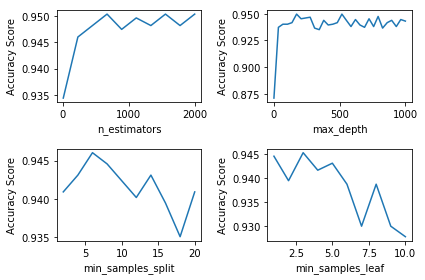

******************************************************
Best Parameters decided by Parameter Tuning: 

           Parameter  Value
0       n_estimators    673
1       max_features   auto
2          max_depth    174
3  min_samples_split      6
4   min_samples_leaf      3
5          bootstrap  False
Training Model after Feature Drop and Hyperparameter Tuning
******************************************************
Features Selected ::  10
Train Accuracy    ::  0.98996350365
Test Accuracy     ::  0.96
Average CrossValidation Score of 5.00 runs: 95.47865

******************************************************
Model = Gradient Boosting Classifier
******************************************************

******************************************************
Features Selected ::  105
Train Accuracy    ::  0.998175182482
Test Accuracy     ::  0.967272727273
Average CrossValidation Score of 5.00 runs: 97.59307

******************************************************
      Dropping Features by featur

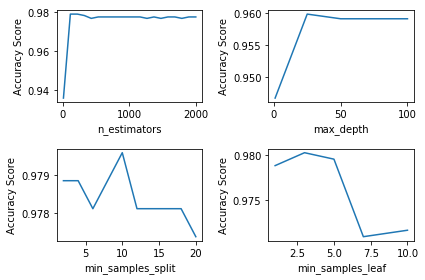

******************************************************
Best Parameters decided by Parameter Tuning: 

           Parameter Value
0       n_estimators   114
1       max_features  auto
2          max_depth    25
3  min_samples_split    10
4   min_samples_leaf     3
Training Model after Feature Drop and Hyperparameter Tuning
******************************************************
Features Selected ::  10
Train Accuracy    ::  1.0
Test Accuracy     ::  0.985454545455
Average CrossValidation Score of 5.00 runs: 98.17596


  Training on 10 best Features from Here On.

******************************************************
                     Model = SVC
******************************************************
******************************************************
Features Selected ::  10
Train Accuracy    ::  0.526459854015
Test Accuracy     ::  0.585454545455
Average CrossValidation Score of 5.00 runs: 53.82937

******************************************************
Model =Decision Tree Class

In [17]:
def main():
    df = readCSV("train.csv", index_column = 'Id')

    testData = df   
    print('******************************************************')
    print('Model = Random Forest Classifier')
    print('******************************************************')  

    #Fit, Test and Drop Features
    model, testData = Classify(testData,classifier=RandomForestClassifier, featureDropFlag=True,
                               featureSize=10, verbose=False)
    
    print("          Training after Feature Drop")
    model, testData = Classify(testData, classifier=RandomForestClassifier)

    #Parameter Tuning    
    param_grid_rf =    {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 2000, num = 10)],
                        'max_features': ['auto', 'sqrt'],
                        'max_depth': [int(x) for x in np.linspace(2, 1000, num = 30)],
                        'min_samples_split': [int(x) for x in np.linspace(2, 20, num = 10)],
                        'min_samples_leaf': [int(x) for x in np.linspace(1, 10, num = 10)],
                        'bootstrap': [True, False]
                        }
    print('Tuning Parameters.. ETA 1Mins... Wait....')
    bestParameters_rf = tune(testData, classifier=RandomForestClassifier, param_grid = param_grid_rf)
    
    #Final training with tuned parameters
    print("Training Model after Feature Drop and Hyperparameter Tuning")
    final_model_rf, testData = Classify(testData, classifier=RandomForestClassifier,
                                        parameters=bestParameters_rf, cvFlag=True)
    #exporting to file
    dumpToFile(final_model_rf, testData, 'model_RForest.pkl')
    
    
    print('******************************************************')
    print('Model = Gradient Boosting Classifier')
    print('******************************************************\n')
    #Fit, Test and Drop Features for Gradient Boosting
    testData = df
    model, testData = Classify(testData, classifier=GradientBoostingClassifier,
                               featureDropFlag=True, featureSize=10, cvFlag=True,verbose=2)
    
    print("          Training after Feature Drop")
    model, testData = Classify(testData, classifier=GradientBoostingClassifier, cvFlag=True)
    
    #Parameter Tuning for Gradient Boosting
    param_grid_gb =    {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 2000, num = 20)],
                        'max_features': ['auto', 'sqrt'],
                        'max_depth': [int(x) for x in np.linspace(1, 100, num = 5)],
                        'min_samples_split': [int(x) for x in np.linspace(2, 20, num = 10)],
                        'min_samples_leaf': [int(x) for x in np.linspace(1, 10, num = 5)],
                        }
    print('Tuning Parameters.. ETA 1Mins... Wait....')
    bestParameters_gb = tune(testData, classifier=GradientBoostingClassifier,
                             param_grid = param_grid_gb, verbose=False)
    
    print("Training Model after Feature Drop and Hyperparameter Tuning")
    final_model_gb, testData = Classify(testData, classifier=GradientBoostingClassifier,
                                        parameters=bestParameters_gb, cvFlag=True)
    dumpToFile(final_model_gb, testData, 'model_GBoosting.pkl')
    
    """
    To Use TestData cleaned by above Model
    'if 0:' to train models on all features.
    """
    if 1:
        df=testData
        print('\n  Training on 10 best Features from Here On.\n')
    
    print('******************************************************')
    print('                     Model = SVC'                      )
    print('******************************************************')
    """
    Hyperparameter tuning for SVM seemed to hang at kernel.
    With kernel set to default, accuracy is around 55% for unseen data (overfitting)
    Hence: default values of SVM were used-
    except for 'gamma' : np.exp(-16.75), that was found by manual binary search
    """
    testData=df
    parameters = {'C' : 10000, 'gamma' : np.exp(-16.75), 'degree': 3, 'kernel': 'rbf'}
    final_model_svc, testData = Classify(testData, classifier=SVC, parameters=parameters)
    dumpToFile(final_model_svc, testData, 'model_SVC.pkl')
    print('******************************************************')
    print('Model =Decision Tree Classifier'                       )
    print('******************************************************')    
    testData=df
    final_model_dtc, testData = Classify(testData,classifier=DecisionTreeClassifier, cvFlag=True, verbose=False)
    dumpToFile(final_model_dtc, testData, 'model_DTC.pkl')
    """"
    print('******************************************************')
    print('       Model = Multi Layer Perceptron')
    print('******************************************************')    

    using Neural Network Classifier
    Input:   testData, parameters(oprional)
    Prints:  Accuracy score
    Returns: trained model clf, testData(features dropped)
    """
    testData=df
    parameters = {'max_iter': 5000}  #Used to avoid non-convergence of optimization warning
    final_model_mlp, testData = Classify(testData, classifier=MLPClassifier, parameters=parameters)
    dumpToFile(final_model_mlp, testData, 'model_MLP.pkl')
    
main()